<h1> Machine Learning Pairs Trading</h1>
<h2> Building a Pairs Detection System using Google Tensorflow</h2>


i:  12
per:  2015-12-15 22:48:28.410997
pers:  20151215
urls:  http://ondemand.websol.barchart.com/getHistory.json?apikey=e569244e3f7684a4fe535d3fd69530ab&symbol=DAZ16&type=daily&startDate=20151215&endDate=20161214 
http://ondemand.websol.barchart.com/getHistory.json?apikey=e569244e3f7684a4fe535d3fd69530ab&symbol=BJZ16&type=daily&startDate=20151215&endDate=20161214
milk size:  253
cheese size:  253
i:  1
per:  2016-11-15 22:48:29.207892
pers:  20161115
urls:  http://ondemand.websol.barchart.com/getHistory.json?apikey=e569244e3f7684a4fe535d3fd69530ab&symbol=DAZ16&type=daily&startDate=20161115&endDate=20161214 
http://ondemand.websol.barchart.com/getHistory.json?apikey=e569244e3f7684a4fe535d3fd69530ab&symbol=BJZ16&type=daily&startDate=20161115&endDate=20161214
milk size:  21
cheese size:  21
i:  2
per:  2016-10-15 22:48:29.824925
pers:  20161015
urls:  http://ondemand.websol.barchart.com/getHistory.json?apikey=e569244e3f7684a4fe535d3fd69530ab&symbol=DAZ16&type=daily&startDate=20161015&en

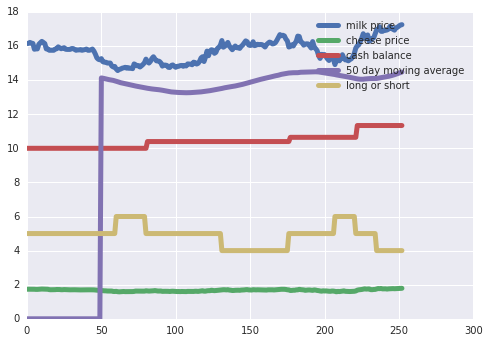

In [96]:
import urllib2
import json
import numpy as np
import statsmodels.tsa.stattools as ts
import pandas as pd
import pprint
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta as dlta
import tensorflow as tf
import matplotlib.pyplot as plot


from pandas.stats.api import ols

class CheeseDataStream(object):
    def __init__(self):
        #websol links for milk and cheese data
        self.milk_DAZ16_daily_url="http://ondemand.websol.barchart.com/getHistory.json?apikey=e569244e3f7684a4fe535d3fd69530ab&symbol=DAZ16&type=daily"
        self.cheese_BJZ16_daily_url="http://ondemand.websol.barchart.com/getHistory.json?apikey=e569244e3f7684a4fe535d3fd69530ab&symbol=BJZ16&type=daily"
        self.df = {}#pd.DataFrame()
        self.periods = [12,1,2,3,4,5,6,9,12]#months
        self.mvadays = 50
        #note: notebook saves in current directory (paths are not relative)
        self.hdf_path = "cheese.h5"
        self.coints = []
        self.limits = [.94,1.00,1.00,1.07] # loosen and tighten buy/sell limits.  Example a tight will buy at .92 the avg and sell at .99.  A loose will buy at 1.07 and sell at 1.01.  Limits are gained from observation.
        self.cash = 1000.00 # starting cash
        self.debug = False
        self.confs = ["1%","5%","10%"] # confidence intervals we want, when we run Augmented Dicky-Fuller
        
    def buildData(self):
        df = self.df
        periods = self.periods

        for i in periods:
            ystdy = dt.now()+dlta(days=-1)
            yststr = ystdy.strftime("%Y%m%d")
            per = dt.now()+dlta(months=-i)
            pers = per.strftime("%Y%m%d")
            print "i: ",i
            print "per: ",per
            print "pers: ",pers

            milkurl = self.milk_DAZ16_daily_url + "&startDate=" + pers + "&endDate=" + yststr   
            cheeseurl = self.cheese_BJZ16_daily_url + "&startDate=" + pers + "&endDate=" + yststr
            print "urls: ",milkurl,"\n",cheeseurl
            df["milks"+str(i)] = self.websolData(milkurl)
            df["cheeses"+str(i)] = self.websolData(cheeseurl)
            print "milk size: ",df["milks"+str(i)].__len__()
            print "cheese size: ",df["cheeses"+str(i)].__len__()


    def websolData(self,url):
        response = urllib2.urlopen(url)
        data = json.load(response)
        prices=[]
        for i in data["results"]:
            prices.append(i["open"])
        if self.debug: print("prices: ",prices,"\n",len(prices))
        return prices

    #This class uses Google Tensorflow to test for cointegration
    #tensorflow will create a single level neural net, where each perceptron is checking for cointegration for the given time interval
    def runTensorflow(self):
        df = self.df
        periods = self.periods
        cadfs=[]
        coints=[]
        
        sess = tf.Session()
        
        #creating perceptrons - one for each cointegration test
        #above we specify we are testing for milk/cheese prices for : 1M,2M,3M,4M,5M,6M,9M and 12M
        for i in periods:
          ms = df["milks"+str(i)]
          cs = df["cheeses"+str(i)]
          
          #Creating and running perceptron(ms,cs)
          #Note: the perceptron code is located outside this class, because it is serialized
          #Since Python classes are also serialized this avoids serializing twice
          inp = tf.constant([ms,cs])
          y = tf.py_func(perceptron, [inp], tf.float32)
          print "sess: ", sess.run(y)
          coints.append(sess.run(y))
          
        self.coints = coints
        return coints

    def trade(self):
        # stor averages, look for deviations away from average,
        # expect cointegration relationship to pull them back to normal
        buyLong=buyShort=sellLong=sellShort=profit=highLoose=totBuys=totSells=buyDiff=chProfit=mProfit=0.0
        lowTight=100.0
        cash = self.cash
        df = self.df
        days = self.mvadays
        limits = self.limits
        
        milks = df["milks12"]
        cheeses = df['cheeses12']

        if self.debug: print "milks: ",milks
        if self.debug: print "cheeses: ",cheeses
        
        if milks.__len__()!=cheeses.__len__():
            print "len mismatch"
            return
        
        #display vars
        dmvas=[]
        cashbals=[]
        buysellsigs=[] # to show on the graph if we're long or short
        
        tight=loose=False
        for i in range(milks.__len__()):
            if i<days:
              dmvas.append(0)
              cashbals.append(cash/100.0)
              buysellsigs.append(5)#neutral
              continue#days needed to calc moving average
            mmavg=np.array(milks[i-days:i]).mean()
            cmavg=np.array(cheeses[i-days:i]).mean()
            dmavg=mmavg-cmavg
            dmvas.append(dmavg)
            cashbals.append(cash/100.0)
            diff=milks[i]-cheeses[i]
            
            if self.debug: print "milk,mmavg,cheese,cmavg,diff,dmavg,dratio: ",milks[i],mmavg,cheeses[i],cmavg,(milks[i]-cheeses[i]),dmavg,diff/dmavg,buyDiff,limits[1]*dmavg
            
            if(diff/dmavg < lowTight):lowTight=diff/dmavg
            if(diff/dmavg > highLoose):highLoose=diff/dmavg
            
            #detect a tight relationship, long the upper price and short the lower price
            #cannot be in tight or loose relationship to execute
            if((not tight and not loose) and diff<limits[0]*dmavg):
                print "buying tight",diff/dmavg
                tight=True
                buyLong=milks[i]
                sellShort=cheeses[i]
                
                print "Long milk at: ",milks[i]
                print "Short cheeses at: ",cheeses[i]
                
                buyDiff=diff
                totBuys+=1
                buysellsigs.append(6)
            #detect a loose relationship, short the upper price and long the lower price
            #cannot be in tight or loose relationship to execute
            elif((not loose and not tight) and diff>limits[3]*dmavg):
                print "buying loose",diff/dmavg
                loose=True
                sellShort=milks[i]
                buyLong=cheeses[i]
                
                print "Short milk at: ",milks[i]
                print "Long cheeses at: ",cheeses[i]
                
                buyDiff=diff
                totBuys+=1
                buysellsigs.append(4)
            #in tight, look for a sell signal 
            elif(tight and diff>limits[1]*dmavg):
                print "untighten",diff/dmavg
                tight = False
                sellLong=milks[i]
                buyShort=cheeses[i]
                mProfit+=sellLong-buyLong
                chProfit+=sellShort-buyShort
                
                #handling cash
                print "cash before: ",cash
                #cash = ((cash/2.0) * (sellLong/buyLong)) + ((cash/2.0) * (sellShort/buyShort))
                cash = cash * sellLong/buyLong #all money in milk
                print "Milk buy,sell prices,delta: ",buyLong,sellLong,sellLong-buyLong
                print "Cheese buy,sell prices,delta: ",buyShort,sellShort,sellShort-buyShort
                print "new cash: ",cash
                
                buyLong=buyShort=sellLong=sellShort=0.0
                totSells+=1
                buysellsigs.append(5)
            #in loose, look for a sell signal
            elif(loose and diff<limits[2]*dmavg):
                print "unloose",diff/dmavg
                loose = False
                buyShort=milks[i]
                sellLong=cheeses[i]
                mProfit+=sellShort-buyShort
                chProfit+=sellLong-buyLong
                
                #handling cash
                print "cash before: ",cash
                #cash = ((cash/2.0) * (sellLong/buyLong)) + ((cash/2.0) * (sellShort/buyShort))
                cash = cash * sellShort/buyShort #all money in milk
                print "Cheese buy,sell prices,delta: ",buyLong,sellLong,sellLong-buyLong
                print "Milk buy,sell prices,delta: ",buyShort,sellShort,sellShort-buyShort
                print "new cash: ",cash
                
                buyLong=buyShort=sellLong=sellShort=0.0
                totSells+=1
                buysellsigs.append(5)
            #no buy/sell triggers this cycle
            elif(tight):
                if self.debug: print "Still tight, waiting to untighten",diff/dmavg
                buysellsigs.append(6)
            elif(loose):
                if self.debug: print "Still loose, waiting to loosen",diff/dmavg
                buysellsigs.append(4)
            else:
                if self.debug: print "All quiet",diff/dmavg
                buysellsigs.append(5)
            
        print "highLoose: ",highLoose
        print "lowTight: ",lowTight
        print "total buys: ",totBuys
        print "total sells: ",totSells
        print "milk profit: ",mProfit
        print "cheese profit: ",chProfit
        print "total profit: ",chProfit+mProfit
        print "Beginning cash: ",self.cash
        print "Final cash: ",cash
        
        plt=plot
        plt.plot(milks, label=str("milk price"), linewidth=5.0)
        plt.plot(cheeses, label=str("cheese price"), linewidth=5.0)
        plt.plot(cashbals, label=str("cash balance"), linewidth=5.0)
        plt.plot(dmvas,label=str(str(self.mvadays)+" day moving average"), linewidth=5.0)
        plt.plot(buysellsigs,label=str("long or short"), linewidth=5.0)
        #plt.title(str(pairs[0] + " " + pairs[1] + " Deltas"),fontsize=20.0)
        #plt.xticks([2,19],[self.startDate,self.endDate])
        plt.legend()
        plt.show()

    def saveHdf(self):
        pass
        #need to clean this up self.df.to_hdf(self.hdf_path,'random',mode='a')

def perceptron(x):
    # print "perceptron milks: ",x[0]
    # print "perceptron cheeses: ",x[1]
  
    confs=["1%","5%","10%"]
    pdf = pd.DataFrame()
    pdf["milks"]=x[0]
    pdf["cheeses"]=x[1]
    
    res = ols(x=pdf["milks"],y=pdf["cheeses"])
    print "res: ",res
    beta_hr = res.beta.x
    pdf["res"] = pdf["milks"] - beta_hr*pdf["cheeses"]

    print "beta_hr: ",beta_hr
    #print "pdf.res: ",pdf["res"]
    
    adf = ts.adfuller(pdf["res"])
    pprint.pprint(adf)
    #cadfs.append(adf)
    print "cadf: ",adf
    coints=[]
    for key in confs:coints.append(np.float32(adf[4][key]))
      
    print "perceptron coints: ",coints

    #self.cadfs = cadfs
    return [coints]
    #return x
  
def main():
    cheese = CheeseDataStream()
    cheese.buildData()
    cadfs = cheese.runTensorflow()
    pprint.pprint(cadfs)
    cheese.trade()
    cheese.saveHdf()

if __name__=="__main__":main()

